=== OPTIMIZATION SETTINGS ===
Smart Padding: True
Use Momentum: True
Adaptive LR: True
Quality Weighting: True
Rank-Based Expect Rank: 8

Client label sets: [[2, 8], [3, 5], [0, 1], [3, 6], [0, 4], [6, 8], [0, 1], [1, 3], [1, 2], [0, 3]]
Client sample sizes: [7000, 7000, 7000, 6800, 6266, 5733, 5200, 4666, 4133, 3600]
Client ranks: [2, 4, 8, 4, 2, 8, 4, 2, 8, 4]

=== Running: zero_pad_product_sum (Optimized) ===

Zero Pad (Optimized) - Using 10 clients with weights: ['0.1151', '0.0815', '0.1390', '0.1322', '0.1043', '0.1090', '0.1029', '0.0818', '0.0761', '0.0581']
[zero_pad_product_sum] Round 01  Test Acc (NO finetune) = 22.84%
Zero Pad (Optimized) - Using 10 clients with weights: ['0.1141', '0.1071', '0.1288', '0.1230', '0.1127', '0.1006', '0.0953', '0.0831', '0.0710', '0.0643']
[zero_pad_product_sum] Round 02  Test Acc (NO finetune) = 23.25%
Zero Pad (Optimized) - Using 10 clients with weights: ['0.1153', '0.1101', '0.1279', '0.1222', '0.1122', '0.1000', '0.0948', '0.0825', '0.0711'

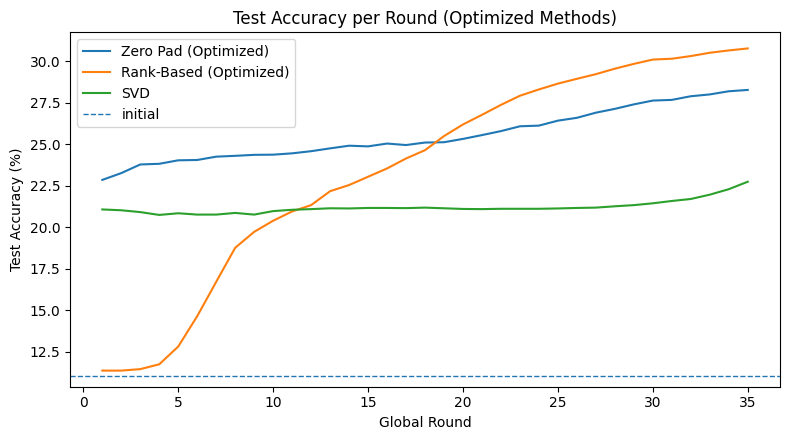

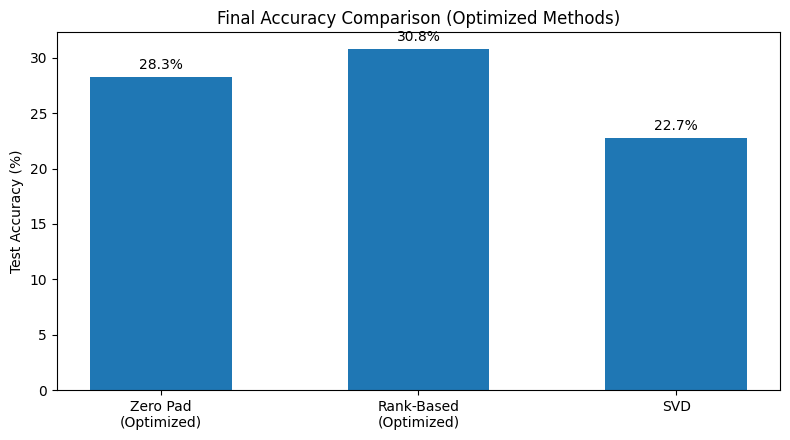

In [1]:
# federated_lora_with_loralayer.py
# Replace LoRA methods with the Linear class from loralayer.py

import torch, random, copy, math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# <-- Use the Linear implementation from your loralayer.py -->
from loralayer import Linear

# =========================
# Config
# =========================
CFG = dict(
    seed=42,
    device="cuda" if torch.cuda.is_available() else "cpu",

    # Clients & data
    num_clients=10,
    classes_per_client=2,
    batch_size=256,
    max_items_per_client=7000,

    double_imbalance=True,

    # Training
    base_pretrain_epochs=0,
    base_lr=1e-3,
    local_epochs=2,
    lr_local=2e-3,
    weight_decay=1e-4,
    global_rounds=35,

    # LoRA
    alpha=16,
    client_ranks=[2,4,8,4,2,8,4,2,8,4],
    target_rank=8,

    rank_based_expect_rank=8,

    do_finetune=False,
    finetune_global_epochs=4,
    finetune_lr=1.5e-3,

    figsize=(8,4.5),

    use_momentum=True,
    momentum_beta=0.9,
    adaptive_lr=True,
    smart_padding=True,
    quality_weighting=True,
)

# =========================
# Utils
# =========================
def set_seed(s):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)

set_seed(CFG["seed"])
DEVICE = torch.device(CFG["device"])

# =========================
# Model (base MLP) - same as before
# =========================
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.drop = nn.Dropout(0.1)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x)); x = self.drop(x)
        x = F.relu(self.fc2(x)); x = self.drop(x)
        return self.fc3(x)

# =========================
# Wrap with loralayer.Linear
# =========================
def wrap_with_lora(model: nn.Module, rank: int, alpha: int):
    """
    Replace model.fc1/fc2/fc3 (nn.Linear) with loralayer.Linear modules.
    The loralayer.Linear constructor signature (from your file) is:
      Linear(in_features, out_features, r=0, lora_alpha=1, lora_dropout=0., fan_in_fan_out=False, merge_weights=True)
    We create the Linear with same in/out dims and r=rank, lora_alpha=alpha, lora_dropout=0.
    Then copy pretrained weight & bias into the new module's weight & bias.
    """
    m = copy.deepcopy(model)

    def _replace_linear(orig_linear: nn.Linear, r: int, alpha: int):
        in_f = orig_linear.in_features
        out_f = orig_linear.out_features
        # instantiate loralayer.Linear with same dims
        new_lin = Linear(
            in_features=in_f,
            out_features=out_f,
            r=r,
            lora_alpha=alpha,
            lora_dropout=0.0,
            fan_in_fan_out=False,
            merge_weights=False
        )
        # copy weights & bias
        with torch.no_grad():
            new_lin.weight.data = orig_linear.weight.data.clone()
            if orig_linear.bias is not None:
                new_lin.bias.data = orig_linear.bias.data.clone()
        return new_lin

    # Replace layers
    m.fc1 = _replace_linear(m.fc1, rank, alpha)
    m.fc2 = _replace_linear(m.fc2, rank, alpha)
    m.fc3 = _replace_linear(m.fc3, rank, alpha)
    return m

def get_lora_state(model: nn.Module):
    """
    Extract lora A/B matrices from loralayer.Linear modules.
    Expect modules at model.fc1/fc2/fc3.
    Returns a dict: { 'fc1': {'A': tensor, 'B': tensor, 'in':..., 'out':..., 'rank':..., 'alpha':...}, ...}
    """
    state = {}
    for name in ["fc1","fc2","fc3"]:
        mod = getattr(model, name)
        # mod should be a loralayer.Linear
        if not hasattr(mod, "lora_A") or not hasattr(mod, "lora_B"):
            # If r==0 or module not LoRA, return zeros
            r = 0
            A = torch.zeros((0, mod.in_features))
            B = torch.zeros((mod.out_features, 0))
            alpha = getattr(mod, "lora_alpha", 1)
        else:
            A = mod.lora_A.detach().cpu().clone()
            B = mod.lora_B.detach().cpu().clone()
            r = getattr(mod, "r", A.shape[0])
            alpha = getattr(mod, "lora_alpha", mod.scaling * (mod.r if hasattr(mod, "r") else 1))
        state[name] = {"A": A, "B": B, "in": mod.in_features, "out": mod.out_features, "rank": r, "alpha": alpha}
    return state

# Broadcast global -> client (truncate/pad to client's rank)
def broadcast_global_to_client(client_model: nn.Module, global_state):
    for name in ["fc1","fc2","fc3"]:
        Lc = getattr(client_model, name)
        A_g = global_state[name]["A"]; B_g = global_state[name]["B"]
        r_g = A_g.shape[0]; r_c = Lc.r if hasattr(Lc, "r") else (Lc.lora_A.shape[0] if hasattr(Lc, "lora_A") else 0)
        in_ = Lc.in_features; out_ = Lc.out_features
        A_new = torch.zeros((r_c, in_))
        B_new = torch.zeros((out_, r_c))
        r_min = min(r_c, r_g)
        if r_min > 0:
            A_new[:r_min, :] = A_g[:r_min, :]
            B_new[:, :r_min] = B_g[:, :r_min]
        # copy into client module (on correct device) with no grad
        with torch.no_grad():
            if hasattr(Lc, "lora_A"):
                Lc.lora_A.copy_(A_new.to(Lc.lora_A.device))
            if hasattr(Lc, "lora_B"):
                Lc.lora_B.copy_(B_new.to(Lc.lora_B.device))

# After aggregation, load into global (global rank fixed = target_rank)
def load_agg_into_global(global_model: nn.Module, agg_state, target_rank:int):
    for name in ["fc1","fc2","fc3"]:
        Lg = getattr(global_model, name)
        # ensure target rank equals Lg.r
        rg = Lg.r if hasattr(Lg, "r") else (Lg.lora_A.shape[0] if hasattr(Lg, "lora_A") else 0)
        assert rg == target_rank, f"Global module rank {rg} != target_rank {target_rank}"
        A_ag = agg_state[name]["A"]; B_ag = agg_state[name]["B"]
        r_ag = A_ag.shape[0]; in_ = Lg.in_features; out_ = Lg.out_features
        A_new = torch.zeros((target_rank, in_)); B_new = torch.zeros((out_, target_rank))
        r_min = min(target_rank, r_ag)
        if r_min > 0:
            A_new[:r_min, :] = A_ag[:r_min, :]
            B_new[:, :r_min] = B_ag[:, :r_min]
        with torch.no_grad():
            if hasattr(Lg, "lora_A"):
                Lg.lora_A.copy_(A_new.to(Lg.lora_A.device))
            if hasattr(Lg, "lora_B"):
                Lg.lora_B.copy_(B_new.to(Lg.lora_B.device))

# =========================
# Data loaders (same as your original)
# =========================
def build_mnist_loaders():
    tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_ds = datasets.MNIST("./data", train=True, download=True, transform=tfm)
    test_ds  = datasets.MNIST("./data", train=False, download=True, transform=tfm)
    return train_ds, test_ds

def indices_by_label_fast(ds):
    if hasattr(ds, "targets"): targets = ds.targets
    elif hasattr(ds, "train_labels"): targets = ds.train_labels
    else: targets = [ds[i][1] for i in range(len(ds))]
    if torch.is_tensor(targets): targets = targets.tolist()
    buckets = defaultdict(list)
    for i, y in enumerate(targets): buckets[int(y)].append(i)
    for k in buckets: random.shuffle(buckets[k])
    return buckets

def make_partitions_double_imbalance(train_ds, num_clients, classes_per_client, max_items_per_client):
    lab2idx = indices_by_label_fast(train_ds)
    probs = np.array([num_clients - i for i in range(10)], dtype=np.float64); probs /= probs.sum()

    client_labels = []
    for _ in range(num_clients):
        labs = np.random.choice(np.arange(10), size=classes_per_client, replace=False, p=probs)
        client_labels.append(sorted(list(map(int, labs))))

    total_train = len(train_ds)
    weights = np.linspace(1.4, 0.6, num_clients); weights /= weights.sum()

    client_indices = []
    for c in range(num_clients):
        pool = []
        for lab in client_labels[c]: pool.extend(lab2idx[lab])
        random.shuffle(pool)
        quota = min(int(total_train * weights[c]), max_items_per_client)
        client_indices.append(pool[:quota])

    return client_indices, client_labels

def make_loader_from_indices(ds, idxs, batch_size, shuffle=True):
    return DataLoader(Subset(ds, idxs), batch_size=batch_size, shuffle=shuffle, drop_last=False)

# =========================
# Train / Eval
# =========================
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    ce = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_samples = 0

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = ce(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], 1.0)
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        total_samples += y.size(0)

    return total_loss / total_samples

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    tot=0; corr=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        tot += y.size(0)
        corr += (pred==y).sum().item()
    return 100.0*corr/tot

@torch.no_grad()
def evaluate_quality(model, loader, device):
    model.eval()
    tot=0; corr=0; total_loss=0.0
    ce = nn.CrossEntropyLoss()
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)
        loss = ce(out, y)
        tot += y.size(0)
        corr += (pred==y).sum().item()
        total_loss += loss.item() * y.size(0)

    acc = 100.0*corr/tot
    avg_loss = total_loss/tot
    return acc, avg_loss

# =========================
# Aggregators (kept as your optimized versions)
# =========================
def zero_pad_product_sum_optimized(states, weights, target_rank, prev_global_state=None):
    print(f"Zero Pad (Optimized) - Using {len(states)} clients with weights: {[f'{w:.4f}' for w in weights]}")
    agg = {}
    for layer in ["fc1","fc2","fc3"]:
        out_ = states[0][layer]["out"]; in_ = states[0][layer]["in"]
        A_sum = torch.zeros((target_rank, in_)); B_sum = torch.zeros((out_, target_rank))
        for st, w in zip(states, weights):
            A = st[layer]["A"]; B = st[layer]["B"]; r = st[layer]["rank"]
            if CFG["smart_padding"] and r < target_rank:
                A_pad = torch.zeros((target_rank, in_))
                B_pad = torch.zeros((out_, target_rank))
                A_pad[:r,:] = A
                B_pad[:,:r] = B
                if r < target_rank:
                    remaining_A = torch.randn(target_rank - r, in_) * 0.001
                    remaining_B = torch.randn(out_, target_rank - r) * 0.001
                    A_pad[r:,:] = remaining_A
                    B_pad[:,r:] = remaining_B
            else:
                A_pad = torch.zeros((target_rank, in_)); A_pad[:r,:] = A
                B_pad = torch.zeros((out_, target_rank));  B_pad[:,:r] = B
            A_sum += w * A_pad; B_sum += w * B_pad
        agg[layer] = {"A": A_sum, "B": B_sum}
    return agg

def rank_based_product_sum_optimized(states, weights, expect_rank=8):
    ranks = set(st["fc1"]["rank"] for st in states)
    assert len(ranks)==1 and list(ranks)[0]==expect_rank, f"need rank={expect_rank}, got {ranks}"
    print(f"Rank-Based (Optimized) - Using {len(states)} clients (rank={expect_rank}) with weights: {[f'{w:.4f}' for w in weights]}")
    agg = {}
    for layer in ["fc1","fc2","fc3"]:
        in_ = states[0][layer]["in"]; out_ = states[0][layer]["out"]; r = expect_rank
        A_sum = torch.zeros((r, in_)); B_sum = torch.zeros((out_, r))
        for st,w in zip(states,weights):
            A_sum += w * st[layer]["A"]; B_sum += w * st[layer]["B"]
        agg[layer] = {"A": A_sum, "B": B_sum}
    return agg

def svd_sum_product(states, weights, target_rank):
    print(f"SVD - Using {len(states)} clients with weights: {[f'{w:.4f}' for w in weights]}")
    agg = {}
    for layer in ["fc1","fc2","fc3"]:
        in_ = states[0][layer]["in"]; out_ = states[0][layer]["out"]
        DW_sum = torch.zeros((out_, in_))
        for st, w in zip(states, weights):
            DW_sum += w * (st[layer]["B"] @ st[layer]["A"])
        U, S, Vh = torch.linalg.svd(DW_sum, full_matrices=False)
        r = min(target_rank, S.numel())
        U = U[:, :r]; Vh = Vh[:r, :]; S = S[:r]
        sqrtS = torch.sqrt(S + 1e-8)
        B_new = U * sqrtS.unsqueeze(0)
        A_new = sqrtS.unsqueeze(1) * Vh
        agg[layer] = {"A": A_new, "B": B_new}
    return agg

class MomentumTracker:
    def __init__(self):
        self.momentum_state = {}
    def apply_momentum(self, current_state, beta=0.9):
        if not self.momentum_state:
            self.momentum_state = copy.deepcopy(current_state)
            return current_state
        momentum_state = {}
        for layer in current_state:
            momentum_state[layer] = {}
            for key in current_state[layer]:
                if isinstance(current_state[layer][key], torch.Tensor):
                    self.momentum_state[layer][key] = (beta * self.momentum_state[layer][key] +
                                                      (1-beta) * current_state[layer][key])
                    momentum_state[layer][key] = self.momentum_state[layer][key]
                else:
                    momentum_state[layer][key] = current_state[layer][key]
        return momentum_state

# =========================
# Federated runner
# =========================
def run_federated_once(aggregator_name: str, shared_objects=None, seed_offset=0):
    set_seed(CFG["seed"] + seed_offset)
    if shared_objects is None or "train_ds" not in shared_objects:
        train_ds, test_ds = build_mnist_loaders()
        client_indices, client_labels = make_partitions_double_imbalance(train_ds, CFG["num_clients"], CFG["classes_per_client"], CFG["max_items_per_client"])
        client_loaders = [make_loader_from_indices(train_ds, idxs, CFG["batch_size"], shuffle=True) for idxs in client_indices]
        client_nsamples = [len(idxs) for idxs in client_indices]
        shared_objects = dict(train_ds=train_ds, test_ds=test_ds, client_indices=client_indices, client_labels=client_labels, client_nsamples=client_nsamples)
    else:
        train_ds = shared_objects["train_ds"]; test_ds = shared_objects["test_ds"]
        client_indices = shared_objects["client_indices"]; client_labels = shared_objects["client_labels"]
        client_nsamples = shared_objects["client_nsamples"]
        client_loaders = [make_loader_from_indices(train_ds, idxs, CFG["batch_size"], shuffle=True) for idxs in client_indices]

    test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

    # init base + global (NO pretrain)
    base = MLP().to(DEVICE)
    global_model = wrap_with_lora(base, rank=CFG["target_rank"], alpha=CFG["alpha"]).to(DEVICE)

    init_acc = evaluate(global_model, test_loader, DEVICE)

    # client models with different ranks
    client_models = []
    for cid in range(CFG["num_clients"]):
        m = wrap_with_lora(base, rank=CFG["client_ranks"][cid], alpha=CFG["alpha"]).to(DEVICE)
        client_models.append(m)

    momentum_tracker = MomentumTracker() if CFG["use_momentum"] else None

    curve = []
    best_no_ft = 0.0
    for rd in range(1, CFG["global_rounds"]+1):
        g_state = get_lora_state(global_model)
        for m in client_models:
            broadcast_global_to_client(m, g_state)

        returned_states = []; returned_ns = []; client_qualities = []
        for cid, m in enumerate(client_models):
            if CFG["adaptive_lr"]:
                lr = CFG["lr_local"] * (0.98 ** (rd - 1))
            else:
                lr = CFG["lr_local"]
            opt = optim.Adam([p for p in m.parameters() if p.requires_grad], lr=lr, weight_decay=CFG["weight_decay"])
            total_loss = 0.0
            for _ in range(CFG["local_epochs"]):
                loss = train_one_epoch(m, client_loaders[cid], opt, DEVICE)
                total_loss += loss
            returned_states.append(get_lora_state(m))
            returned_ns.append(client_nsamples[cid])
            if CFG["quality_weighting"]:
                acc, avg_loss = evaluate_quality(m, client_loaders[cid], DEVICE)
                quality = acc / (1 + avg_loss)
                client_qualities.append(quality)

        # aggregation choice
        if aggregator_name == "zero_pad_product_sum":
            if CFG["quality_weighting"] and client_qualities:
                combined_weights = [ns * q for ns, q in zip(returned_ns, client_qualities)]
                w = np.array(combined_weights, dtype=np.float64)
            else:
                w = np.array(returned_ns, dtype=np.float64)
            w = (w / w.sum()).tolist()
            agg = zero_pad_product_sum_optimized(returned_states, w, target_rank=CFG["target_rank"])

        elif aggregator_name == "rank_based_product_sum":
            expect_rank = CFG["rank_based_expect_rank"]
            sel = [i for i in range(CFG["num_clients"]) if CFG["client_ranks"][i]==expect_rank]
            assert len(sel)>0, "no same-rank clients"
            states_sel = [returned_states[i] for i in sel]
            sizes = [returned_ns[i] for i in sel]
            if CFG["quality_weighting"] and client_qualities:
                qualities_sel = [client_qualities[i] for i in sel]
                combined_weights = [s * q for s, q in zip(sizes, qualities_sel)]
                weights = [w / sum(combined_weights) for w in combined_weights]
            else:
                weights = [s / sum(sizes) for s in sizes]
            print(f"Rank-based selected clients {sel} with sample sizes {sizes}")
            agg = rank_based_product_sum_optimized(states_sel, weights, expect_rank=expect_rank)

        elif aggregator_name == "svd_sum_product":
            if CFG["quality_weighting"] and client_qualities:
                combined_weights = [ns * q for ns, q in zip(returned_ns, client_qualities)]
                w = np.array(combined_weights, dtype=np.float64)
            else:
                w = np.array(returned_ns, dtype=np.float64)
            w = (w / w.sum()).tolist()
            agg = svd_sum_product(returned_states, w, target_rank=CFG["target_rank"])
        else:
            raise ValueError("Unknown aggregator")

        if CFG["use_momentum"] and momentum_tracker:
            agg = momentum_tracker.apply_momentum(agg, beta=CFG["momentum_beta"])

        load_agg_into_global(global_model, agg, target_rank=CFG["target_rank"])

        acc = evaluate(global_model, test_loader, DEVICE)
        best_no_ft = max(best_no_ft, acc)
        curve.append(acc)
        print(f"[{aggregator_name}] Round {rd:02d}  Test Acc (NO finetune) = {acc:.2f}%")

    final_no_ft = curve[-1] if len(curve)>0 else init_acc
    return {
        "init_acc": init_acc,
        "curve": curve,
        "final_no_ft": final_no_ft,
        "best_no_ft": best_no_ft,
        "shared": shared_objects
    }

# =========================
# Run all three + summary + plots (NO FINETUNE)
# =========================
if __name__ == "__main__":
    set_seed(CFG["seed"])
    train_ds, test_ds = build_mnist_loaders()
    client_indices, client_labels = make_partitions_double_imbalance(train_ds, CFG["num_clients"], CFG["classes_per_client"], CFG["max_items_per_client"])
    client_nsamples = [len(idxs) for idxs in client_indices]
    shared = dict(train_ds=train_ds, test_ds=test_ds, client_indices=client_indices, client_labels=client_labels, client_nsamples=client_nsamples)

    print("=== OPTIMIZATION SETTINGS ===")
    print(f"Smart Padding: {CFG['smart_padding']}")
    print(f"Use Momentum: {CFG['use_momentum']}")
    print(f"Adaptive LR: {CFG['adaptive_lr']}")
    print(f"Quality Weighting: {CFG['quality_weighting']}")
    print(f"Rank-Based Expect Rank: {CFG['rank_based_expect_rank']}")
    print()
    print("Client label sets:", client_labels)
    print("Client sample sizes:", client_nsamples)
    print("Client ranks:", CFG["client_ranks"])

    results = {}
    for i, agg in enumerate(["zero_pad_product_sum", "rank_based_product_sum", "svd_sum_product"]):
        print(f"\n=== Running: {agg} (Optimized) ===\n")
        out = run_federated_once(agg, shared_objects=shared, seed_offset=i+1)
        results[agg] = out

    # Summary & plots

     # 1 Training curves (NO finetune)
    init_acc = results["zero_pad_product_sum"]["init_acc"]
    print("\n====== SUMMARY (MNIST, Optimized Methods) ======")
    print(f"Initial global (before rounds) : {init_acc:.2f}%")
    for agg, out in results.items():
        print(f"[{agg}]  NO-finetune (last/best): {out['final_no_ft']:.2f}% / {out['best_no_ft']:.2f}%")

    plt.figure(figsize=CFG["figsize"])
    for agg, out in results.items():
        label_map = {
            "zero_pad_product_sum": "Zero Pad (Optimized)",
            "rank_based_product_sum": "Rank-Based (Optimized)",
            "svd_sum_product": "SVD"
        }
        plt.plot(range(1, len(out["curve"])+1), out["curve"], label=label_map.get(agg, agg))
    plt.axhline(init_acc, linestyle="--", linewidth=1, label="initial")
    plt.xlabel("Global Round"); plt.ylabel("Test Accuracy (%)")
    plt.title("Test Accuracy per Round (Optimized Methods)")
    plt.legend(); plt.tight_layout()
    plt.show()



    # 2 Final comparison bars (NO finetune only)
    names = ["Zero Pad\n(Optimized)", "Rank-Based\n(Optimized)", "SVD"]
    last_noft = [results["zero_pad_product_sum"]["final_no_ft"],
                 results["rank_based_product_sum"]["final_no_ft"],
                 results["svd_sum_product"]["final_no_ft"]]

    x = np.arange(len(names)); w = 0.55
    plt.figure(figsize=CFG["figsize"])
    bars = plt.bar(x, last_noft, width=w)
    plt.xticks(x, names)
    plt.ylabel("Test Accuracy (%)")
    plt.title("Final Accuracy Comparison (Optimized Methods)")

    # Add value labels on bars
    for bar, val in zip(bars, last_noft):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
     
